# Import Libraries

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Importation and Cleaning

### Notes:

(1) Attendance from book

(2) Batting, pitching, standings from fangraphs

(3) wanted win percentage, ERA+ and OPS+ (easy to interpret and captures performance)

(4) Only need stats for visiting team because home team variable accounts for home team

(5) For visiting team, want to further break it down to see if fans like high scoring teams, low scoring teams or just good teams

(6) Relatively clean dataset - no missing data

In [95]:
# Load in data and view columns
attend = pd.read_csv('../data/attendance.csv')
batting = pd.read_excel('../data/batting.xlsx')
pitching = pd.read_excel('../data/pitching.xlsx')
standings = pd.read_excel('../data/standings.xlsx').rename(columns = {'W-L%': 'win_percent'})

In [96]:
batting.columns

Index(['Tm', '#Bat', 'BatAge', 'R/G', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+',
       'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LOB'],
      dtype='object')

In [97]:
pitching.columns

Index(['Tm', '#P', 'PAge', 'RA/G', 'W', 'L', 'W-L%', 'ERA', 'G', 'GS', 'GF',
       'CG', 'tSho', 'cSho', 'SV', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB',
       'SO', 'HBP', 'BK', 'WP', 'BF', 'ERA+', 'FIP', 'WHIP', 'H9', 'HR9',
       'BB9', 'SO9', 'SO/W', 'LOB'],
      dtype='object')

In [98]:
standings.columns

Index(['Rk', 'Tm', 'W', 'L', 'win_percent', 'R', 'RA', 'Rdiff', 'SOS', 'SRS',
       'pythWL', 'Luck', 'vEast', 'vCent', 'vWest', 'Inter', 'Home', 'Road',
       'ExInn', '1Run', 'vRHP', 'vLHP', '≥.500', '<.500'],
      dtype='object')

In [99]:
attend.columns

Index(['year', 'home_team', 'month', 'day', 'attend', 'day_of_week',
       'opponent', 'temp', 'skies', 'day_night', 'cap', 'shirt', 'fireworks',
       'bobblehead'],
      dtype='object')

In [100]:
df = (
    attend
    .merge(batting[['Tm', 'OPS+']], left_on = 'opponent', right_on = 'Tm')
    .merge(pitching[['Tm', 'ERA+']], left_on = 'opponent', right_on = 'Tm')
    .merge(standings[['Tm', 'win_percent']], left_on = 'opponent', right_on = 'Tm')
    .rename(columns = {
        'OPS+': 'visiting_OPS+',
        'ERA+': 'visiting_ERA+',
        'win_percent': 'visiting_win_percent'
    })
)
df = df.loc[:, ~df.columns.str.startswith('Tm')]

In [101]:
df.head()

,year,home_team,month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead,visiting_OPS+,visiting_ERA+,visiting_win_percent
0,2012,Baltimore Orioles,APR,6,46773,Friday,Minnesota Twins,59,Clear,Day,NO,NO,NO,NO,98,86,0.407
1,2012,Baltimore Orioles,APR,7,31532,Saturday,Minnesota Twins,63,Clear,Night,NO,NO,NO,NO,98,86,0.407
2,2012,Baltimore Orioles,APR,8,14738,Sunday,Minnesota Twins,68,Clear,Day,NO,NO,NO,NO,98,86,0.407
3,2012,Boston Red Sox,AUG,2,37191,Thursday,Minnesota Twins,84,Cloudy,Night,NO,NO,NO,NO,98,86,0.407
4,2012,Boston Red Sox,AUG,3,37285,Friday,Minnesota Twins,88,Cloudy,Night,NO,NO,NO,NO,98,86,0.407


In [102]:
# No missing values
df.isnull().sum()

year                    0
home_team               0
month                   0
day                     0
attend                  0
day_of_week             0
opponent                0
temp                    0
skies                   0
day_night               0
cap                     0
shirt                   0
fireworks               0
bobblehead              0
visiting_OPS+           0
visiting_ERA+           0
visiting_win_percent    0
dtype: int64

In [103]:
# Convert month to numerical representation for easier subsequent analysis
# Create date column for time series analysis
df['month'] = np.where(
    df['month'] == 'APR', 4,
    np.where(df['month'] == 'MAY', 5,
    np.where(df['month'] == 'JUN', 6,
    np.where(df['month'] == 'JUL', 7,
    np.where(df['month'] == 'AUG', 8,
    np.where(df['month'] == 'SEP', 9,
    10))))))
df['year'] = 2012
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [104]:
# ID Column to analyze variables with interesting behavior
df['id'] = df.index + 1
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('id')))
df = df.reindex(columns=cols)

# Exploratory Data Analysis

### Areas to Explore:

(1) Correlation matrix

(2) Attendance by team, day of week, etc.

(3) Distribution of attendance - does it need to be normalized in some way?

(4) Basic incremental lift of attendance by promotion

(5) Affect of weather

(6) Break down attendance for specific teams or overall

(7) Feature engineering - marquee matchup (other team is good or draws a big crowd)

(8) Feature engineering - rivalries

### Correlation Matrix

**Takeaways**: 

(1) Temperature is most correlated, followed by visiting OPS+

(2) Generally small correlations all around

<AxesSubplot:>

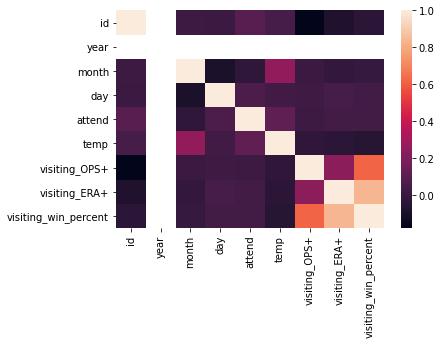

In [105]:
corr = df.select_dtypes('number').corr()
sns.heatmap(corr)

### Impact of Visiting OPS, ERA, and Winning Percentage

**Takeaways:**

(1) Outside of the lowest bin in each range, which usually has a very small sample since few teams score extremely poorly in a category, facing better teams generally leads to better attendance

(2) The strip plots show there are fewer very low attendance games when playing better teams

(3) These variables should be used in the machine learning model since they provide some predictive ability. Check for collinearity between winning percentage, OPS and ERA, since teams that win more will naturally score well in these categories.

In [106]:
df['win_percent_bin'] = pd.cut(df['visiting_win_percent'], bins=[x / 100 for x in range(35,65,5)], labels=[f'{l}-{l+5}' for l in range(35,60,5)])
df['OPS_bin'] = pd.cut(df['visiting_OPS+'], bins=range(80,115,5), labels=[f'{l}-{l+5}' for l in range(80,110,5)])
df['ERA_bin'] = pd.cut(df['visiting_ERA+'], bins=range(80,125,5), labels=[f'{l}-{l+5}' for l in range(80,120,5)])

Text(0, 0.5, 'Average Attendance')

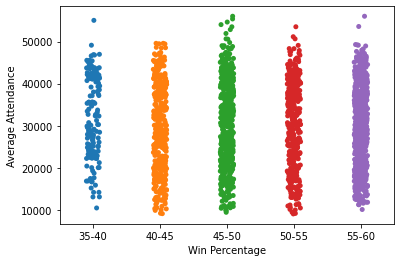

In [107]:
sns.stripplot(data = df, x = 'win_percent_bin', y = 'attend')
plt.xlabel('Win Percentage')
plt.ylabel('Average Attendance')

<AxesSubplot:xlabel='win_percent_bin', ylabel='attend'>

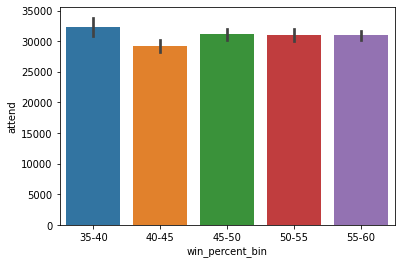

In [108]:
sns.barplot(data = df, x = 'win_percent_bin', y = 'attend')

<AxesSubplot:xlabel='OPS_bin', ylabel='attend'>

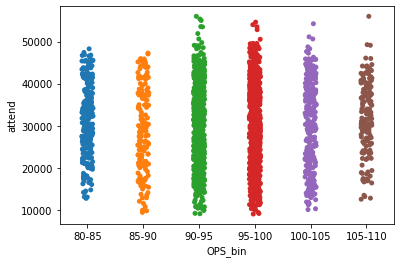

In [109]:
sns.stripplot(data = df, x = 'OPS_bin', y = 'attend')

<AxesSubplot:xlabel='OPS_bin', ylabel='attend'>

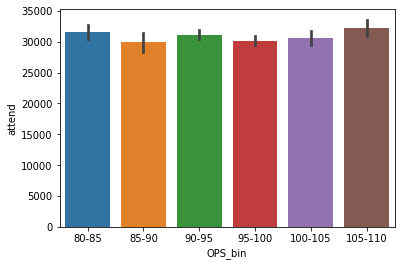

In [110]:
# Smaller sample size in initial bars - after that, seems to increase
sns.barplot(data = df, x = 'OPS_bin', y = 'attend')

<AxesSubplot:xlabel='ERA_bin', ylabel='attend'>

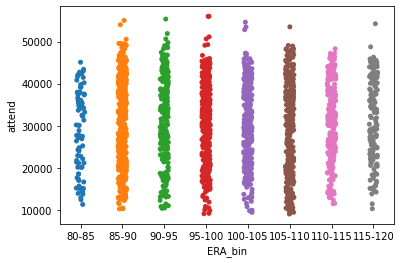

In [111]:
sns.stripplot(data = df, x = 'ERA_bin', y = 'attend')

<AxesSubplot:xlabel='ERA_bin', ylabel='attend'>

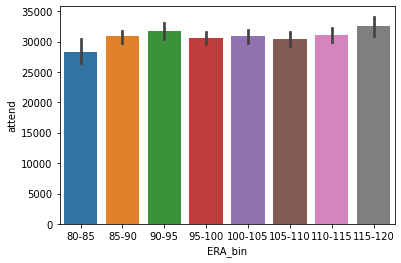

In [112]:
# Once again, generally see a positive trend
sns.barplot(data = df, x = 'ERA_bin', y = 'attend')

### Analysis of Rivals

**Takeaways:**

(1) Graphically, it does not seem that division rivals lead to significantly higher attendance

(2) However, it is clear that inner-city rivalries (eg: Cubs vs. White Sox, Mets vs. Yankees, etc.) lead to higher attendance

(3) Create a new feature to flag these inner-city rivalries

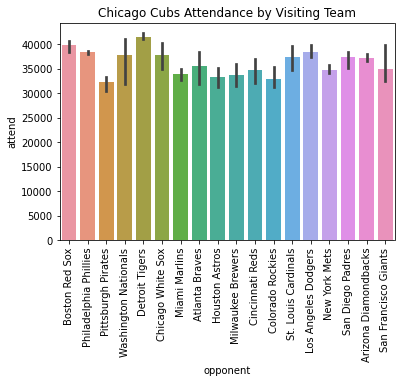

In [113]:
chc = df[df['home_team'] == 'Chicago Cubs']
sns.barplot(data = chc, x = 'opponent', y = 'attend')
plt.xticks(rotation = 90)
plt.title("Chicago Cubs Attendance by Visiting Team");

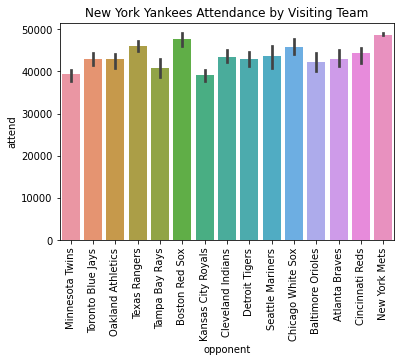

In [114]:
nyy = df[df['home_team'] == 'New York Yankees']
sns.barplot(data = nyy, x = 'opponent', y = 'attend')
plt.xticks(rotation = 90)
plt.title("New York Yankees Attendance by Visiting Team");

In [115]:
# Create a column to flag inner-city rivalry games, which clearly have higher attendance
df['city_rivals_flag'] = np.where(
    ((df['home_team'] == 'New York Mets') & (df['opponent'] == 'New York Yankees') |
    (df['home_team'] == 'New York Yankees') & (df['opponent'] == 'New York Mets')) |
    ((df['home_team'] == 'Chicago Cubs') & (df['opponent'] == 'Chicago White Sox') |
    (df['home_team'] == 'Chicago White Sox') & (df['opponent'] == 'Chicago Cubs')),
    1,
    0
)

### Day of week analysis

**Takeaways:**

(1): Games are much more frequently attended Friday-Sunday than Monday-Thursday -- create a weekend variable (includes Friday) to account for this.

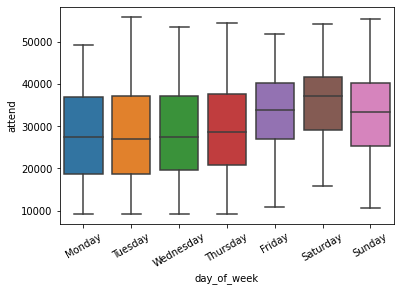

In [116]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data = df, x = 'day_of_week', y = 'attend', order = weekdays)
plt.xticks(rotation = 30);

In [117]:
df['weekend_flag'] = np.where(
    df['day_of_week'].isin(['Friday', 'Saturday', 'Sunday']),
    1,
    0
)

### Day vs. Night Analysis

**Takeaways:**

(1) Attendance is higher by about 2,000 on average at day games.

(2) From Monday-Saturday, attendance is higher at day games. However, on Sunday, this relationship flips, and night games have far greater attendance. This is due to the fact that every Sunday game is played during the day except for the premier Sunday Night Baseball game on national television.

(3) To account for these relationships, I split the day_night variable into four different categories: non-Sunday day games, non-Sunday night games, Sunday day games and Sunday Night Baseball.

In [118]:
df.groupby('day_night')['attend'].mean()

day_night
Day      32493.940945
Night    30110.367554
Name: attend, dtype: float64

In [119]:
attend_day_night = df.groupby(['day_of_week', 'day_night'], as_index = False)[['attend']].mean()

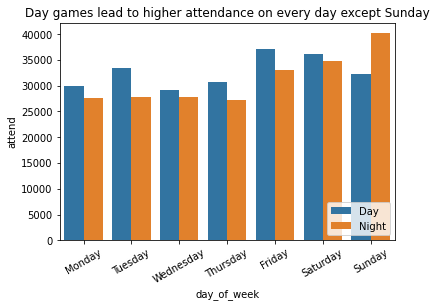

In [120]:
sns.barplot(data = attend_day_night, x = 'day_of_week', y = 'attend', hue = 'day_night', order = weekdays)
plt.legend(loc = 'lower right')
plt.xticks(rotation = 30)
plt.title("Day games lead to higher attendance on every day except Sunday");

In [121]:
df['day_night_categories'] = np.where(
    (df['day_of_week'] != 'Sunday') & (df['day_night'] == 'Day'), 'non_sunday_day',
    np.where((df['day_of_week'] != 'Sunday') & (df['day_night'] == 'Night'), 'non_sunday_night',
    np.where((df['day_of_week'] == 'Sunday') & (df['day_night'] == 'Day'), 'sunday_day',
            'sunday_night'))
)

### Home Opener Analysis

**Takeaways:**

(1) As expected, teams draw much higher crowds in their home openers. Over 43,000 fans attend these games as opposed to an average of just over 30,000 for all other games.

In [122]:
# Create a running count of home game number to identify each team's home opener
df['home_game_number'] = df.sort_values(['month', 'day']) \
                           .groupby('home_team') \
                           .cumcount() + 1
df['home_opener_flag'] = np.where(
    df['home_game_number'] == 1,
    1,
    0
)

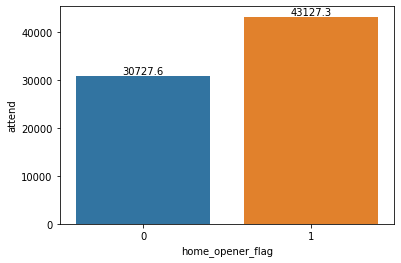

In [123]:
ax = sns.barplot(data = df, x = 'home_opener_flag', y = 'attend', ci = None)
for i in ax.containers:
    ax.bar_label(i,)

### Holidays Analysis

**Takeaways:**

(1) Considered 5 potential holidays: Mother's Day, Memorial Day, Father's Day, Independence Day, and Labor Day. Found that attendance was higher than average for all but Labor Day.

(2) Thus, created a holiday flag, including all holidays except Labor Day.

In [124]:
df['potential_holidays'] = np.where(
    (df['month'] == 5) & (df['day'] == 13), "Mother's Day",
    np.where((df['month'] == 5) & (df['day'] == 28), 'Memorial Day',
    np.where((df['month'] == 6) & (df['day'] == 17), "Father's Day",
    np.where((df['month'] == 7) & (df['day'] == 4), 'Independence Day',
    np.where((df['month'] == 9) & (df['day'] == 3), 'Labor Day',
    'non-holiday'))))
)

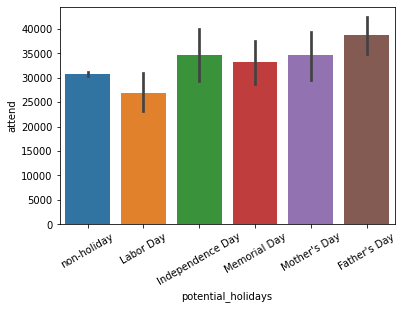

In [125]:
sns.barplot(data = df, x = 'potential_holidays', y = 'attend')
plt.xticks(rotation = 30);

In [126]:
df['holiday_flag'] = np.where(
    ((df['month'] == 5) & (df['day'] == 13)) |
    ((df['month'] == 5) & (df['day'] == 28)) |
    ((df['month'] == 6) & (df['day'] == 17)) |
    ((df['month'] == 7) & (df['day'] == 4)),
    1,
    0
)

### Attendance over Time

**Takeaways:**

(1) When plotting the seven-day rolling average attendance, there a few observable trends. First, there are clear spikes in atttendance around opening day and holidays. Second, attendance is generally highest from June to August. Since opening day games and holidays are already accounted for, this shows that month should be a useful variable to use to predict attendance. I will watch out for collinearity between month and temperature, though I expect there to be a certain degree of difference between the variables given that attendance drops off in September despite still-hot temperatures.

(2) The violinplot shows marginal differences in attendance by month, with highest attendance in June and July. I will use month instead of week as a predictor to avoid overfitting.

In [127]:
df = df.sort_values('date').set_index('date')
attend_by_date = df.groupby('date')[['attend']].mean()
df['rolling_attend'] = attend_by_date['attend'].rolling(window = 7, min_periods = 7).mean()

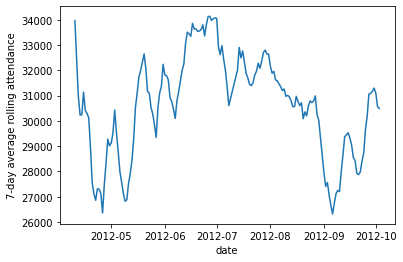

In [128]:
sns.lineplot(data = df, x = 'date', y = 'rolling_attend', ci = None)
plt.ylabel('7-day average rolling attendance');

In [129]:
df.reset_index(inplace = True)

In [130]:
monthly_attendance = df.sort_values('month').groupby('month', as_index = False)[['attend']].mean()

<AxesSubplot:xlabel='month', ylabel='attend'>

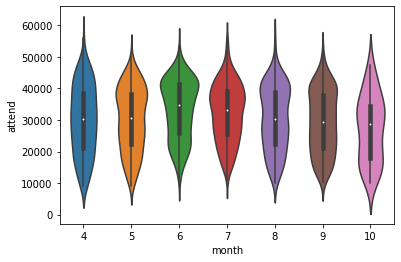

In [131]:
sns.violinplot(data = df, x = 'month', y = 'attend')

<AxesSubplot:xlabel='month', ylabel='attend'>

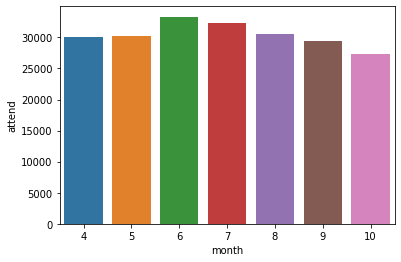

In [132]:
sns.barplot(data = df, x = 'month', y = 'attend', ci = None)

### Weather Analysis

**Takeaways:**

(1) The average attendance between clear and cloudy games is roughly the same at about 32,000, and attendance is lower at rainy games at about 29,000. The fact that games played in domed stadiums leads to lower attendance is more a product of teams with small fanbases like the Tampa Bay Rays playing in these stadiums. Therefore, the only relevant information here is whether the game was rainy, so I will create a flag for rainy weather and drop the rest.

(2): When doing temperature analysis, I removed three extreme outliers to allow for an easier comparison between groups and to prevent the data from being skewed. There is a large sample of data from games where temperature is between 75 and 90 degrees and attendance is generally higher during these games. This explains why there is a significant correlation between temperature and attendance - it will definitely be used in our analysis.

In [133]:
df.groupby('skies')[['attend']].mean()

,attend
skies,
Clear,32000.790257
Cloudy,32071.613033
Dome,24151.116418
Rainy,29144.347826


In [134]:
df['rainy_flag'] = np.where(df['skies'] == 'Rainy', 1, 0)

In [135]:
len(df[df['temp'] < 40])

3

In [136]:
len(df[df['temp'] > 105])

1

In [137]:
# Remove 4 outliers for more effective analysis
df = df[(df['temp'] > 40) & (df['temp'] < 106)]

<AxesSubplot:xlabel='temp', ylabel='Count'>

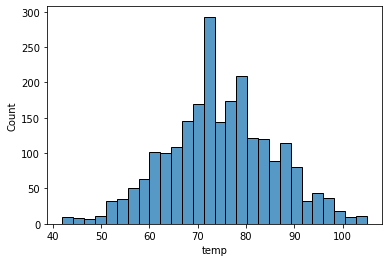

In [138]:
# Temperature is relatively normally distributed
sns.histplot(data = df, x = 'temp')

In [139]:
df['temp_bin'] = pd.cut(df['temp'], bins=range(40,110,5), labels=[f'{l}-{l+5}' for l in range(40,105,5)])

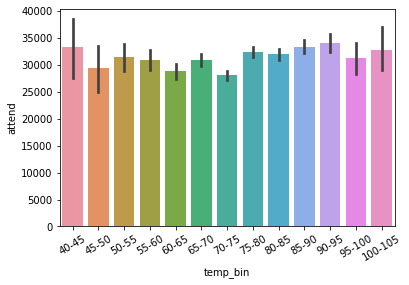

In [140]:
# In bins with a significant sample size, attendance is highest when temperature is between 75 and 90 degrees
sns.barplot(data = df, x = 'temp_bin', y = 'attend')
plt.xticks(rotation = 30);

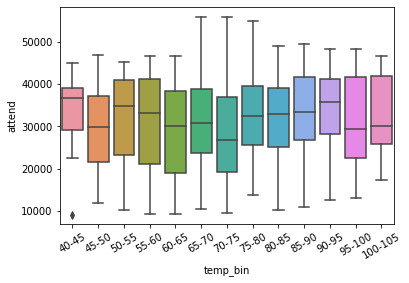

In [141]:
sns.boxplot(data = df, x = 'temp_bin', y = 'attend')
plt.xticks(rotation = 30);

### Promotion Analysis

**Takeaways:**

(1) On average, attendance at promoted games is higher than attendance at non-promoted games by 2,834. While this is convincing evidence, it is not conclusive proof that promotions significantly increase attendance due to potential collinearity of promotions being run during highly-sought games. More advanced methods such as feature importance analysis will be used to confirm this relationship.

(2) Promoted games have higher attendance than non-promoted games in all months, but especially April. Promotions are most frequently run from June-August.

(3) Interestingly, non-promoted games have higher attendance than promoted games on the weekends. Perhaps building a machine learning model using only weekend games will confirm this relationship.

In [142]:
df['promotion_flag'] = np.where(
    (df['cap'] == 'YES') | (df['shirt'] == 'YES') | (df['fireworks'] == 'YES'),
    1,
    0
)

In [143]:
attendance_promo = df.groupby('promotion_flag')[['attend']].mean()

In [144]:
print('Overall uplift in attendance through promotions:', 
      int(attendance_promo.loc[1]['attend'] - attendance_promo.loc[0]['attend']))

Overall uplift in attendance through promotions: 2834


In [145]:
promos_by_month = df.groupby(['month', 'promotion_flag'], as_index = False)[['attend']].mean()

In [146]:
# Count the number of promotions per month
num_promos_by_month = df[df['promotion_flag'] ==1].groupby(['month'], as_index = False)[['id']].count() \
                      .rename(columns = {'id': 'num_promos'})

<AxesSubplot:xlabel='month', ylabel='num_promos'>

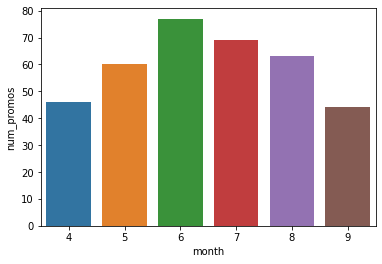

In [147]:
# Most promotions are in June through August, when attendance is highest
sns.barplot(data = num_promos_by_month, x = 'month', y = 'num_promos')

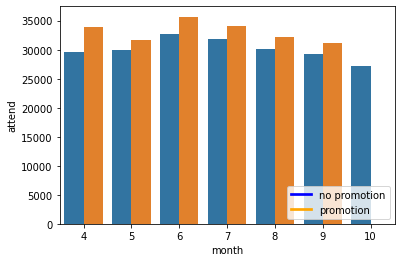

In [148]:
# Attendance is higher in promoted games across all months - no clear relationship here
sns.barplot(data = promos_by_month, x = 'month', y = 'attend', hue = 'promotion_flag')
my_labels = ['no promotion', 'promotion']
plt.legend(loc = 'lower right', labels = my_labels)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('orange')

In [149]:
# Promotions by weekday vs. weekend games
weekend_promos = df.groupby(['weekend_flag', 'promotion_flag'], as_index = False)[['attend']].mean()
weekend_promos['weekend_flag'] = np.where(
        weekend_promos['weekend_flag'] == 1, 
        'weekend',
        'weekday'
)
weekend_promos['promotion_flag'] = np.where(
        weekend_promos['promotion_flag'] == 1, 
        'promotion',
        'no_promotion'
)

Text(0.5, 0, 'Day Type')

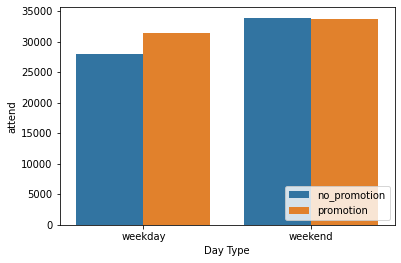

In [150]:
# Promotions are most effective on weekdays
sns.barplot(data = weekend_promos, x = 'weekend_flag', y = 'attend', hue = 'promotion_flag')
plt.legend(loc = 'lower right')
plt.xlabel('Day Type')

# Selecting Data for Model Building

After completing exploratory analyssis where I determined what information was potentially relevant, I went back and selected the variables to consider using during the model-building process.

In [151]:
df.columns

Index(['date', 'id', 'year', 'home_team', 'month', 'day', 'attend',
       'day_of_week', 'opponent', 'temp', 'skies', 'day_night', 'cap', 'shirt',
       'fireworks', 'bobblehead', 'visiting_OPS+', 'visiting_ERA+',
       'visiting_win_percent', 'win_percent_bin', 'OPS_bin', 'ERA_bin',
       'city_rivals_flag', 'weekend_flag', 'day_night_categories',
       'home_game_number', 'home_opener_flag', 'potential_holidays',
       'holiday_flag', 'rolling_attend', 'rainy_flag', 'temp_bin',
       'promotion_flag'],
      dtype='object')

In [152]:
model_df = df[[
    'id',
    'date',
    'home_team',
    'opponent',
    'attend',
    'temp',
    'day_night_categories',
    'visiting_OPS+',
    'visiting_ERA+',
    'visiting_win_percent',
    'city_rivals_flag',
    'weekend_flag',
    'home_opener_flag',
    'holiday_flag',
    'rainy_flag',
    'cap',
    'shirt',
    'fireworks',
    'bobblehead',
    'promotion_flag'
]]

In [153]:
path = '../data/'
model_df.to_csv(path + 'model_data.csv')